### Generating Images with VAEs and GANs
- In this assignment, you will implement two models: a Variational Auto Encoder (VAE) and a Generative Adversarial Network (GAN), each for the task of image generation.
- You will train these models on Fashion-MNIST, a dataset containing grayscale images of shoes, clothes, hats, etc.
- For each task, we only provide abstract instructions.  You have the freedom to implement the model from scratch and customize helper functions for your convenience.
- We will primarily grade your work based on the quality of generated images by visualization.
- GAN models may need longer training time to produce high quality images. If you need to accelerate your experiment, please consider using Google's Colab which provides free GPU or TPU runtime.
- So that compute does not become a bottleneck during development, you may want to start with smaller and/or simpler models, verify that training is making progress (i.e., generation quality is improving), and then focus on design changes to further improve quality.




### Variational Auto-Encoder (VAE)
- A VAE is an image generation model following the design of an auto-encoder, consisting of an encoder and a decoder trained by minimizing the reconstruction error.  Unlike conventional autoencoders, VAEs parameterize the latent space with a prior distribution, thereby providing a statistical interpretation of the reconstruction process.
- A VAE model optimizes the Evidence Lower Bound (ELBO) as follows:
$$\log p_{\theta}(x) \geq E_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)] - D_{KL}\left(q_{\phi}\left(z|x\right)|| p\left(z\right)\right)$$
where $q_{\phi}, p_{\theta}$ are instantiated as encoder and decoder, respectively. $p(z)$ is the prior distribution, which is usually chosen as the Normal distribution $\mathcal{N}(0,1)$.
- After training the VAE, you are expected to generate two diversified samples (function provided), which should hold similar content as the input.

In [171]:
"""
Import PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

In [172]:
"""
Enable CUDA if the GPU is available
"""
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

Ankle Boot


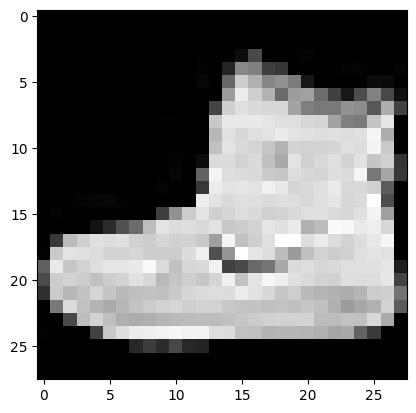

In [173]:
"""
Define the dataloader for the Fashion MNIST dataset.
"""
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

#### Define VAE Model (TODO) [15 points]


- Suggestion: define an encoder, decoder, and reparameterization module.
- The reparameterization module should allow us to produce a sample from a conditional distribution (given predicted mean and covariance) in a manner that is suitable for training via backprop.  See discussion of the univariant Gaussian case in Section 2.4 of "Auto-Encoding Variational Bayes".
- Implement the forward pass of the VAE model.

In [177]:
"""
A Convolutional Variational Autoencoder
"""
"""YOUR CODE HERE"""
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.mu = nn.Linear(128 * 4 * 4 , 2)
        self.log_variance = nn.Linear(128 * 4 * 4 , 2)

        self.fc = nn.Linear(2, 128 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_variance):
        # z = μ + σε
        sigma = torch.exp(0.5 * log_variance)
        epsilon = torch.randn_like(sigma)r
        return mu + (sigma * epsilon)

    def forward(self, x):
        x = self.encoder(x)

        mu = self.mu(x)
        log_variance = self.log_variance(x)

        z = self.reparameterize(mu, log_variance)

        z = self.fc(z)
        z = self.decoder(x)

        #cut 32,32 to 28,28
        z = z[:, :, 2:-2, 2:-2]

        return z, mu, log_variance

#### Complete the Training Loop (TODO) [15 points]
- Implement the complete training loop for the VAE model.

In [180]:
"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-3
num_epochs = 20

"""
Initialize the network and the Adam optimizer
"""

"""YOUR CODE HERE"""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = VAE()
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

"""
Training the network for a given number of epochs
"""

"""YOUR CODE HERE"""
def loss_func(x, image, mu, log_variance):
    reconstruction_loss = F.binary_cross_entropy(x, image, reduction='sum')
    kl_divergence_loss = -0.5 * torch.sum(1 + log_variance - mu.exp() - log_variance.exp())
    return reconstruction_loss + kl_divergence_loss

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (img, _) in enumerate(train_loader):
        img = img.to(device)
        
        optimizer.zero_grad()

        z, mu, log_variance = net(img)
        loss = loss_func(z, img, mu, log_variance)
        
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Epoch: [{}/{}], Train: [{}/{} ({:.0f}%)], Loss: {:.5f}'.format(
                epoch + 1, num_epochs,
                batch_idx * len(img), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()
            ))

Epoch: [1/20], Train: [0/60000 (0%)], Loss: 55207.24609
Epoch: [1/20], Train: [10000/60000 (17%)], Loss: 27933.93945
Epoch: [1/20], Train: [20000/60000 (33%)], Loss: 28906.98242
Epoch: [1/20], Train: [30000/60000 (50%)], Loss: 26506.65820
Epoch: [1/20], Train: [40000/60000 (67%)], Loss: 27226.41211
Epoch: [1/20], Train: [50000/60000 (83%)], Loss: 27843.05859
Epoch: [2/20], Train: [0/60000 (0%)], Loss: 26647.68555
Epoch: [2/20], Train: [10000/60000 (17%)], Loss: 26664.84570
Epoch: [2/20], Train: [20000/60000 (33%)], Loss: 27571.63477
Epoch: [2/20], Train: [30000/60000 (50%)], Loss: 25728.80273
Epoch: [2/20], Train: [40000/60000 (67%)], Loss: 26371.69336
Epoch: [2/20], Train: [50000/60000 (83%)], Loss: 27057.22266
Epoch: [3/20], Train: [0/60000 (0%)], Loss: 26209.54688
Epoch: [3/20], Train: [10000/60000 (17%)], Loss: 26184.09766
Epoch: [3/20], Train: [20000/60000 (33%)], Loss: 27291.83203
Epoch: [3/20], Train: [30000/60000 (50%)], Loss: 25326.36133
Epoch: [3/20], Train: [40000/60000 (67%

#### Visualize the output
- Display the VAE output by generating multiple samples from the latent space.
- You can modify this function accordingly to fit your implementation.

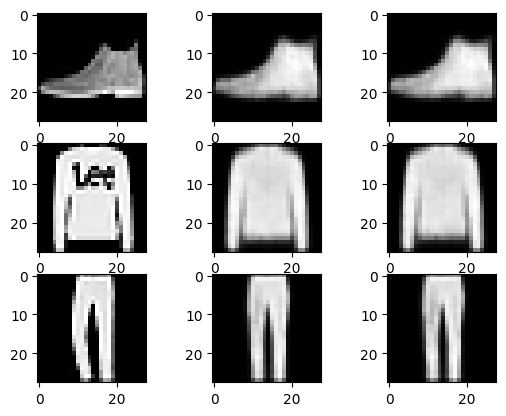

In [181]:

"""
The following part takes two images from test loader to feed into the VAE.
Both the original image and generated image(s) from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np

net.eval()
with torch.no_grad():
    imgs, _ = list(test_loader)[0]
    imgs = imgs.to(device)
    fig, ax = plt.subplots(3,3)
    ax = ax.reshape(-1)
    for i in range(3):
      for j in range(3):
        if j == 0:
          # input image
          img = np.transpose(imgs[i].cpu().numpy(), [1,2,0])
          ax[i*3+j].imshow(np.squeeze(img), cmap = 'gray')
        else:
          # vae generation results
          out, mu, logVAR = net(imgs)
          outimg = np.transpose(out[i].cpu().numpy(), [1,2,0])
          ax[i*3+j].imshow(np.squeeze(outimg), cmap = 'gray')
    plt.show()


Generative Adversarial Network (GAN)
- A GAN is a generation model trained to convert the samples from prior distribution $z$ to the target domain $x$, e.g., images or text, in an unsupervised fashion.
- A GAN consists of a generator ($G$) and discriminator ($D$), where $G$ is trained to produce realistic samples of the target domain, while $D$ learns to distinguish between samples from the generator and those from the real domain, thereby serving as a critic providing supervision to optimize $G$.
- GAN training typically follows two alternating steps that update the parameters of $D$ and $G$ according to opposing objectives in a two-player game:
  1. $\max_D \log\left(D\left(x\right)\right) + \log\left(1 - D\left(G\left(z\right)\right)\right)$
  2.$\max_G \log\left(D\left(G\left(z\right)\right)\right)$
- Note that here, we are using an alternative, empirically motivated, objective for $G$ instead of $\min_G \log\left(1 - D\left(G\left(z\right)\right)\right)$. In practice, this change should yield faster progress at the start of training.

#### Define GAN Model (TODO) [15 points]
- Define the generator and discriminator for the GAN model.

In [203]:
"""
Define the generator
"""
"""YOUR CODE HERE"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.generator(x)
        return output.view(x.size(0), 1, 28, 28)

"""
Define the discriminator
"""
"""YOUR CODE HERE"""
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4), 
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

#### Complete the Training Loop (TODO) [15 points]
- Implement the complete training loop for the GAN model.
- You can monitor the loss curve between generator and discriminator to tune the hyperparameters.
- The losses of the generator and discriminator should converge toward some non-zero values at the end.  The generator's loss is generally higher than discriminator's loss.

In [204]:
"""
Initialize Hyperparameters
"""
lr = 0.0002
num_epochs = 20

"""
Initialize the network and the Adam optimizer
"""

"""YOUR CODE HERE"""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = Generator()
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

optimizer_gen = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_discrim = torch.optim.Adam(discriminator.parameters(), lr=lr)

"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""

"""YOUR CODE HERE"""
for epoch in range(num_epochs):
    epoch_discrim = 0
    epoch_gen = 0

    for batch_idx, (img, _) in enumerate(train_loader):
        batch_size = img.size(0)
        img = img.to(device)

        #Discriminator
        optimizer_discrim.zero_grad()
        fake = generator(torch.randn(batch_size, 100).to(device))

        discrim_output_img = discriminator(img)
        discrim_output_fake_img = discriminator(fake.detach())

        loss_discrim = -torch.mean(torch.log(discrim_output_img) + torch.log(1 - discrim_output_fake_img))
        loss_discrim.backward()
        optimizer_discrim.step()

        #Generator
        optimizer_gen.zero_grad()
        discrim_output_fake_img = discriminator(fake)

        loss_gen = -torch.mean(torch.log(discrim_output_fake_img))
        loss_gen.backward()
        optimizer_gen.step()

        epoch_discrim += loss_discrim.item()
        epoch_gen += loss_gen.item()

    print('Epoch: [{}/{}], Loss for Discriminator: {:.5f}, Loss for Generator: {:.5f}'.format(
        epoch + 1, num_epochs,
        epoch_discrim / len(train_loader),
        epoch_gen / len(train_loader)
    ))


Epoch: [1/20], Loss for Discriminator: 1.32761, Loss for Generator: 1.00641
Epoch: [2/20], Loss for Discriminator: 1.29554, Loss for Generator: 0.91799
Epoch: [3/20], Loss for Discriminator: 1.30378, Loss for Generator: 0.93889
Epoch: [4/20], Loss for Discriminator: 1.17192, Loss for Generator: 1.05448
Epoch: [5/20], Loss for Discriminator: 1.20648, Loss for Generator: 1.17646
Epoch: [6/20], Loss for Discriminator: 1.14316, Loss for Generator: 1.11301
Epoch: [7/20], Loss for Discriminator: 1.17915, Loss for Generator: 1.14226
Epoch: [8/20], Loss for Discriminator: 1.08590, Loss for Generator: 1.27083
Epoch: [9/20], Loss for Discriminator: 1.07136, Loss for Generator: 1.26397
Epoch: [10/20], Loss for Discriminator: 1.12501, Loss for Generator: 1.20626
Epoch: [11/20], Loss for Discriminator: 1.04747, Loss for Generator: 1.25324
Epoch: [12/20], Loss for Discriminator: 1.06458, Loss for Generator: 1.25728
Epoch: [13/20], Loss for Discriminator: 1.19969, Loss for Generator: 1.15722
Epoch: [

#### Visualize the output
- Display the GAN output by running multiple samples of the latent space.
- You can modify this function accordingly to fit your implementation.

19


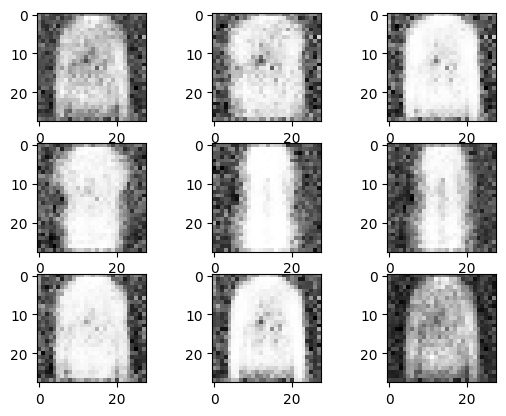

In [207]:
print(epoch)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3,3)
ax = ax.reshape(-1)
for i in range(9):
  ax[i].imshow(fake[i,0].cpu().data.numpy(), cmap = 'gray')
plt.show()